In [1]:
import pandas as pd
import numpy as np

import pickle

from src import image_transformations
from src.combinatorial_space.minicolumn import Minicolumn, LearnEnum
from src.context_transform import ContextTransformations
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

Загрузка **MNIST**

In [2]:
df = pd.read_csv('data/MNIST/mnist_train.csv', header=None, nrows=10000)

Инициализация Миниколлонки

In [8]:
max_number = 5000
count_subimages_for_image = 10
window_size = [4, 4]
minicolumn = Minicolumn(
    space_size=1,
    max_count_clusters=30000,
    count_in_dimensions=64, in_random_bits=25,
    count_out_dimensions=20, out_random_bits=15,
    seed=42,
    code_aligment_threshold=4,
    in_threshold_activate=1,
    out_threshold_activate=1,
    in_threshold_modify=3,
    out_threshold_modify=3,
    base_lr=0.3, threshold_bin=0.1
)
transforms = ContextTransformations(count_directs=4)

Обучение миниколонки

In [9]:
def sleep__(minicolumn):
    print('Сон')
    clusters_of_points, the_same_clusters = minicolumn.sleep(
        threshold_active=0.6,
        threshold_in_len=3,
        threshold_out_len=2
    )
    sum_ = 0
    for ind, cluster in enumerate(clusters_of_points):
        if len(cluster) == 0:
            sum_ += 1
    print(
        'Неактивные точки:', sum_,
        '. Одинаковые кластеры:', the_same_clusters
    )

means = []
delta = []
ind = 0
opt_context_numbes = []
opt_image_sample = []
opt_out = []
opt_ind_arr = []

for i in range(1, 10000):
    np.sort(np.random.permutation(64)[:25])
    np.sort(np.random.permutation(20)[:15])

In [10]:
for image_number in range(max_number):
    label, image = image_transformations.get_image(df, image_number)
    print(image_number, label)
    start = minicolumn.count_clusters
    for subimage_number in range(count_subimages_for_image):
        codes, context_numbes, image_sample = transforms.get_all_codes(image, True, True)
        if codes is None:
            continue
        opt_ind, out_code, status = minicolumn.learn(
            codes,
            ind, 
            threshold_controversy_in=20, 
            threshold_controversy_out=5
        )
        opt_context_numbes.append(context_numbes[opt_ind])
        opt_image_sample.append(image_sample)
        opt_out.append(out_code)
        opt_ind_arr.append(opt_ind)

        if status == LearnEnum.LEARN:
            print('№', ind, 'Всего кластеров:', minicolumn.count_clusters)
            means.append(np.mean([len(p.clusters) for p in minicolumn.space]))
        elif status == LearnEnum.SLEEP:
#             sleep__(minicolumn)
            pass
        ind += 1

    print('Изменение кол-ва кластеров', minicolumn.count_clusters - start)
    delta.append(minicolumn.count_clusters - start)
    if minicolumn.is_sleep() or minicolumn.count_clusters - start < 60:
#         sleep__(minicolumn)
        pickle.dump(minicolumn, open('data/minicolumn.pkl', 'wb'))
        break


0 5
№ 0 Всего кластеров: 1
№ 1 Всего кластеров: 1
№ 2 Всего кластеров: 2
№ 3 Всего кластеров: 3
№ 4 Всего кластеров: 4
№ 5 Всего кластеров: 5
№ 6 Всего кластеров: 6
№ 7 Всего кластеров: 7
№ 8 Всего кластеров: 8
№ 9 Всего кластеров: 9
Изменение кол-ва кластеров 9


([-3, -2], (array([ 4,  7,  9, 17]),), 1)

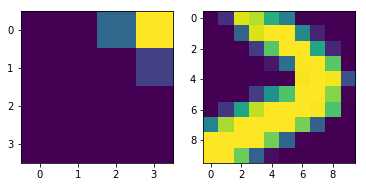

In [11]:
ind = 1
plt.figure(1)
plt.subplot(121)
plt.imshow(transforms.get_context_image(opt_image_sample[ind], opt_context_numbes[ind]));
plt.subplot(122)
plt.imshow(opt_image_sample[ind]);
opt_context_numbes[ind], np.where(opt_out[ind]), opt_ind_arr[ind]

In [96]:
stats = []
for ind, point in enumerate(minicolumn.space):
    stats.append(point.statistics)

all_clusters = {}
n = 33
for im_num in range(n):
    ind = 0
    clusters = []
    for point in stats:
        for cluster in point:
            ind += 1
            if np.sum(np.uint8(np.array(cluster) == im_num)) > 0:
                clusters.append(ind)
    all_clusters[im_num] = clusters

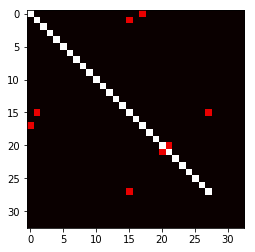

In [98]:
matr = []
max_im = 33
threshold = 0.5
for a in range(max_im):
    matr.append([])
    for b in range(max_im):
        if len(all_clusters[a]) > 0 and len(all_clusters[b]) > 0:
            if b > a:
                matr[-1].append(len(set(all_clusters[a]).intersection(all_clusters[b])) / len(all_clusters[b]) > threshold)
            elif b < a:
                matr[-1].append(len(set(all_clusters[a]).intersection(all_clusters[b])) / len(all_clusters[a]) > threshold)
            else:
                matr[-1].append(3)
        else:
            matr[-1].append(0)
            
plt.imshow(matr, cmap='hot', interpolation='nearest');

Количество кластеров, в зависимости от номера шага

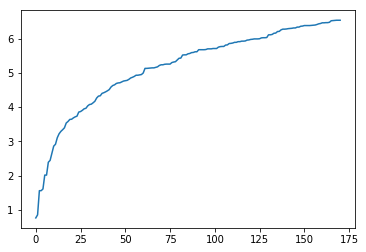

In [6]:
plt.plot(np.arange(len(means)), means);

Предсказание

In [8]:
window_size = [4, 4]
transforms = ContextTransformations(count_directs=4)
minicolumn = pickle.load(open('data/minicolumn.pkl', 'rb'))

In [9]:
images = []
out_codes = []
start_number = 5000
max_number = 5030
for ind, image_number in enumerate(range(start_number, max_number)):
    label, image = image_transformations.get_image(df, image_number)
    for subimage_number in range(0, count_subimages_for_image):
        codes, context_numbes, image_sample = transforms.get_all_codes(
            image,
            context_numbers_flag=True, 
            image_sample_falg=True
        )
        if codes is None:
            continue
        in_code, out_code, opt_ind = minicolumn.unsupervised_learning(codes, 20, 5)
        if in_code is not None:
            images.append(transforms.get_context_image(image_sample, context_numbes[opt_ind]))
            out_codes.append(out_code)
    print(ind)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


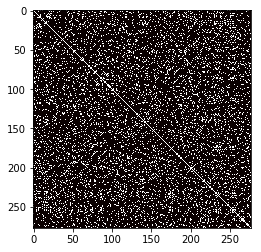

In [15]:
s = 0
dist_matrix = []
graph = []
threshold = 5
for i in range(len(out_codes)):
    dist_matrix.append([])
    graph.append([])
    for j in range(len(out_codes)):
        is_edge = np.sum(np.uint8(np.logical_xor(out_codes[i], out_codes[j]))) < threshold
        dist_matrix[-1].append(np.uint(is_edge))
        if is_edge:
            graph[-1].append(j)

plt.imshow(dist_matrix, cmap='hot', interpolation='nearest');

In [16]:
check = np.zeros(len(graph))
clusters = []
def dfs(current_vertex, clusters):
    check[current_vertex] = 1
    clusters[-1].append(current_vertex)
    for vertex in graph[current_vertex]:
        if check[vertex] == 0:
            dfs(vertex, clusters)
            
for vertex in np.arange(0, len(graph)):
    if not check[vertex]:
        clusters.append([])
        dfs(vertex, clusters)

In [20]:
len(clusters[0])

277